# Airline flights delay analysis

This study is aiming to have simple analysis on airline flights delay data. Using linear regression to provide sights on what are the trends for flights based on different viariants.

## Environment setup

In [184]:
import pandas as pd
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import datetime
from mpl_toolkits.basemap import Basemap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch
from matplotlib.patches import Ellipse
from collections import OrderedDict
import seaborn as sb
from scipy.optimize import curve_fit
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# Hide all warnings
import warnings
warnings.filterwarnings('ignore')

### 1. Overview of datasets

In [2]:
df = pd.read_csv('./flight-delays/flights.csv', low_memory=False)
print('Dataframe dimentions: ', df.shape)

# Provide column info and number of null values
tab_info = pd.DataFrame(df.dtypes).T.rename(index={0: 'column type'})
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0: 'null values(nb)'}))
tab_info = tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
tab_info

Dataframe dimentions:  (5819079, 31)


YEAR  MONTH    DAY DAY_OF_WEEK AIRLINE FLIGHT_NUMBER  \
column type      int64  int64  int64       int64  object         int64   
null values(nb)      0      0      0           0       0             0   
null values (%)      0      0      0           0       0             0   

                TAIL_NUMBER ORIGIN_AIRPORT DESTINATION_AIRPORT  \
column type          object         object              object   
null values(nb)       14721              0                   0   
null values (%)    0.252978              0                   0   

                SCHEDULED_DEPARTURE      ...      ARRIVAL_TIME ARRIVAL_DELAY  \
column type                   int64      ...           float64       float64   
null values(nb)                   0      ...             92513        105071   
null values (%)                   0      ...           1.58982       1.80563   

                DIVERTED CANCELLED CANCELLATION_REASON AIR_SYSTEM_DELAY  \
column type        int64     int64              object          float64   
null values(nb)        0         0             5729195          4755640   
null values (%)        0         0             98.4554           81.725   

                SECURITY_DELAY AIRLINE_DELAY LATE_AIRCRAFT_DELAY WEATHER_DELAY  
column type            float64       float64             float64       float64  
null values(nb)        4755640       4755640             4755640       4755640  
null values (%)         81.725        81.725              81.725        81.725  

[3 rows x 31 columns]

We will aggregate the overall flight delay information and plot on map. A general distribution will be noticed. 

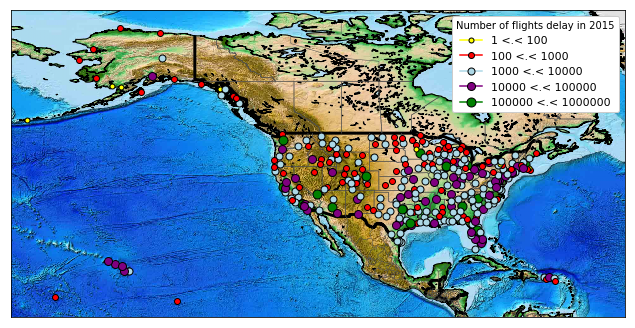

In [3]:
airports = pd.read_csv('./flight-delays/airports.csv')
count_flights = df['ORIGIN_AIRPORT'].value_counts()
plt.figure(figsize=(11, 11))
colors = ['yellow', 'red', 'lightblue', 'purple', 'green', 'orange']
size_limits = [1, 100, 1000, 10000, 100000, 1000000]
labels = []
for i in range(len(size_limits) - 1):
    labels.append('{0} <.< {1}'.format(size_limits[i], size_limits[i+1]))
    
map = Basemap(resolution='i',llcrnrlon=-180, urcrnrlon=-50, llcrnrlat=10, urcrnrlat=75, lat_0=0, lon_0=0,)
map.etopo()
map.drawcoastlines()
map.drawcountries(linewidth=3)
map.drawstates(color='0.3')

for index, (code, y, x) in airports[['IATA_CODE', 'LATITUDE', 'LONGITUDE']].iterrows():
    if code in count_flights:
        x, y = map(x, y)
        isize = [i for i, val in enumerate(size_limits) if val < count_flights[code]]
        ind = isize[-1]
        map.plot(x, y, marker='o', markersize = ind+5, markeredgewidth = 1, color = colors[ind], markeredgecolor='k', label = labels[ind])
             
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
key_order = ('1 <.< 100', '100 <.< 1000', '1000 <.< 10000',
             '10000 <.< 100000', '100000 <.< 1000000')
new_label = OrderedDict()
for key in key_order:
    new_label[key] = by_label[key]
    
plt.legend(new_label.values(), new_label.keys(), loc = 1, prop = {'size': 11}, title='Number of flights delay in 2015', frameon = True, framealpha = 1)
plt.show()

### 2. Data polishing

We change date, time into python datetime. To reduce the computation time, I choose to run only Jan data to analysis

In [4]:
df = df[df['MONTH'] == 1]
df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])

Depature time, arrival time are in integer. We'd better parse them into datetime in order to analysis them easier.

In [5]:
# Parse time string in datetime 
def format_time(time_data):
    if pd.isnull(time_data):
        return np.nan
    else:
        time_data = time_data % 2400
        time_data = '{0:04d}'.format(int(time_data))
        result = datetime.time(int(time_data[0:2]), int(time_data[2:4]))
        return result

# Combine date and time 
def combine_date_time(input_array):
    if any(pd.isnull(i) for i in input_array):
        return np.nan
    else:
        return datetime.datetime.combine(input_array[0], input_array[1])
    
def flight_date_time(df, col):
    array = []
    for index, cols in df[['DATE', col]].iterrows():
        if pd.isnull(cols[1]):
            array.append[np.nan]
        else:
            if int(cols[1]) == 2400:
                cols[0] += datetime.datetime(days=1)
            
            cols[1] = format_time(cols[1])
            array.append(combine_date_time(cols))
    return pd.Series(array)
        

Modify time data:

In [6]:
df['SCHEDULED_DEPARTURE'] = flight_date_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_time)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_time)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_time)

# Output first 5 rows data
df.loc[:5, ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]

SCHEDULED_DEPARTURE DEPARTURE_TIME SCHEDULED_ARRIVAL ARRIVAL_TIME  \
0 2015-01-01 00:05:00       23:54:00          04:30:00     04:08:00   
1 2015-01-01 00:10:00       00:02:00          07:50:00     07:41:00   
2 2015-01-01 00:20:00       00:18:00          08:06:00     08:11:00   
3 2015-01-01 00:20:00       00:15:00          08:05:00     07:56:00   
4 2015-01-01 00:25:00       00:24:00          03:20:00     02:59:00   
5 2015-01-01 00:25:00       00:20:00          06:02:00     06:10:00   

   DEPARTURE_DELAY  ARRIVAL_DELAY  
0            -11.0          -22.0  
1             -8.0           -9.0  
2             -2.0            5.0  
3             -5.0           -9.0  
4             -1.0          -21.0  
5             -5.0            8.0

We will only keep necessary data. Hence the dataframe should be re-modified.

In [7]:
variables_to_drop = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK','DATE', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']

df.drop(variables_to_drop, axis = 1, inplace=True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df.loc[:5]

AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT SCHEDULED_DEPARTURE  \
0      AS            ANC                 SEA 2015-01-01 00:05:00   
1      AA            LAX                 PBI 2015-01-01 00:10:00   
2      US            SFO                 CLT 2015-01-01 00:20:00   
3      AA            LAX                 MIA 2015-01-01 00:20:00   
4      AS            SEA                 ANC 2015-01-01 00:25:00   
5      DL            SFO                 MSP 2015-01-01 00:25:00   

  DEPARTURE_TIME  DEPARTURE_DELAY SCHEDULED_ARRIVAL ARRIVAL_TIME  \
0       23:54:00            -11.0          04:30:00     04:08:00   
1       00:02:00             -8.0          07:50:00     07:41:00   
2       00:18:00             -2.0          08:06:00     08:11:00   
3       00:15:00             -5.0          08:05:00     07:56:00   
4       00:24:00             -1.0          03:20:00     02:59:00   
5       00:20:00             -5.0          06:02:00     06:10:00   

   ARRIVAL_DELAY  SCHEDULED_TIME  ELAPSED_TIME  
0          -22.0           205.0         194.0  
1           -9.0           280.0         279.0  
2            5.0           286.0         293.0  
3           -9.0           285.0         281.0  
4          -21.0           235.0         215.0  
5            8.0           217.0         230.0

Reset all the null values. 

In [8]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)'] = (df.shape[0] - missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop=True)
df.dropna(inplace=True)

### 3. Comparing different airlines

Read airlines information and store into dict for future use

In [9]:
airlines = pd.read_csv('./flight-delays/airlines.csv')
airline_companies = dict(zip(airlines.IATA_CODE, airlines.AIRLINE))

#### 3.1 Basic statistical result
Let's figure out the basic statistics by different airlines

In [10]:
def get_stat(group):
    return {'MIN': group.min(), 'MAX': group.max(), 'COUNT': group.count(), 'MEAN': group.mean(), 'STD': group.std()}

stats_by_airline = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stat).unstack()
stats_by_airline = stats_by_airline.sort_values('COUNT')
stats_by_airline

COUNT     MAX       MEAN   MIN        STD
AIRLINE                                             
VX        4647.0   397.0   6.896277 -20.0  29.941858
HA        6408.0  1003.0   1.311954 -26.0  24.172076
F9        6735.0   696.0  17.910765 -32.0  54.895548
NK        8632.0   557.0  13.073100 -28.0  40.360375
AS       13151.0   444.0   3.072086 -47.0  28.392908
B6       20482.0   500.0   9.988331 -27.0  33.543318
MQ       27568.0   780.0  15.995865 -29.0  41.898394
US       32478.0   638.0   5.175011 -26.0  26.787275
UA       37363.0   886.0  13.885555 -40.0  37.979476
AA       43074.0  1988.0  10.548335 -29.0  47.798771
OO       46655.0   931.0  11.999957 -48.0  42.502458
EV       48084.0   726.0   9.678895 -33.0  39.126165
DL       63676.0  1184.0   5.888215 -26.0  32.893646
WN       98060.0   604.0   9.453426 -15.0  27.518164

We will plot a graph to characterize the flight delay by each airlines

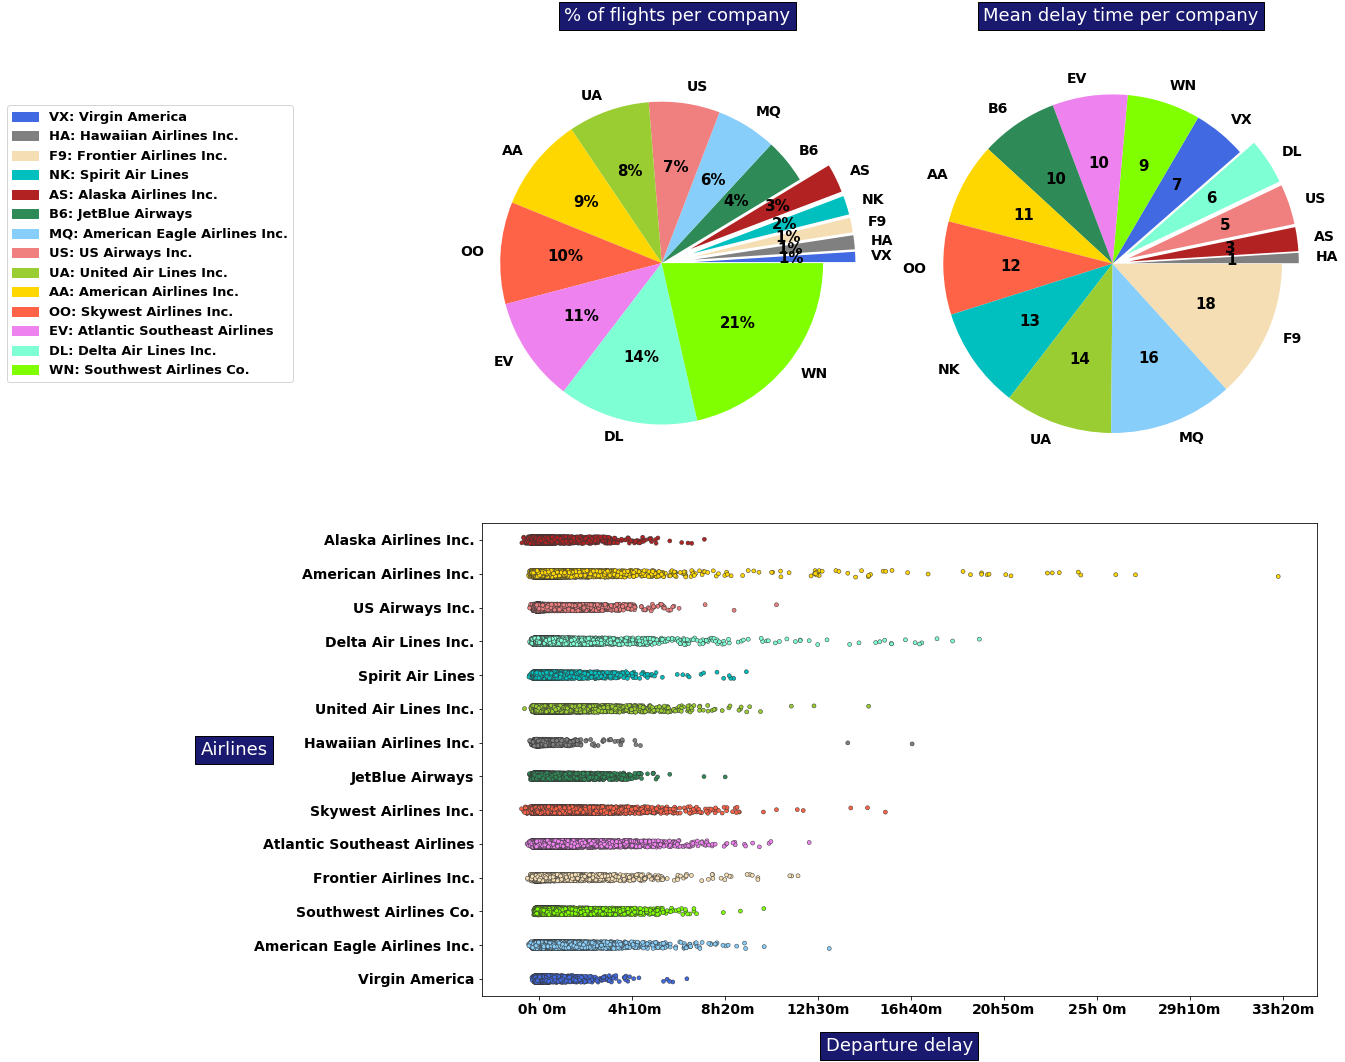

In [11]:
font = {'family' : 'normal', 'weight': 'bold', 'size': 15}
mpl.rc('font', **font)

# Set colors
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 
          'lightskyblue', 'lightcoral', 'yellowgreen', 'gold', 'tomato', 
          'violet', 'aquamarine', 'chartreuse']

fig = plt.figure(1, figsize=(16, 15))
gs = GridSpec(2, 2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

# Pie chart on delay distribution for different airlines
labels = [a for a in stats_by_airline.index]
sizes = stats_by_airline['COUNT'].values

# 20000 is a tuned value 
explode = [0.2 if sizes[i] < 20000 else 0.0 for i in range(len(airline_companies))]

patches, texts, autotexts = ax1.pie(sizes, explode=explode, labels=labels, 
                                    colors=colors, autopct='%1.f%%', shadow=False, startangle=0)

for i in range(len(airline_companies)):
    texts[i].set_fontsize(14)
ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor': 'midnightblue', 'pad':5}, color = 'w', fontsize=18)

# set legend
airline_handler = []
for i in range(len(airline_companies)):
    airline_handler.append(mpatches.Patch(color=colors[i], 
                                        label = '{0}: {1}'.format(stats_by_airline.index[i], airline_companies[stats_by_airline.index[i]])))
ax1.legend(handles=airline_handler, bbox_to_anchor=(0.1, 0.9), fontsize=13, bbox_transform=plt.gcf().transFigure)

# Plot mean delay time for airlines
size_colors = dict(zip(stats_by_airline.MEAN, colors))
sorted_colors = list(OrderedDict(sorted(size_colors.items())).values())
sorted_stat = stats_by_airline.sort_values(by=['MEAN'])
sizes = sorted_stat['MEAN'].values
sizes = [max(m,0) for m in sizes]
labels = [a for a in sorted_stat.index]

# size 6 is a tuned value
explode = [0.0 if sizes[i] > 6 else 0.1 for i in range(len(airline_companies))]
patches, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=sorted_colors, shadow=False, startangle=0, 
                                    autopct=lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))

for i in range(len(airline_companies)):
    texts[i].set_fontsize(14)
    
ax2.axis('equal')
ax2.set_title('Mean delay time per company', bbox={'facecolor':'midnightblue', 'pad':5}, color='w', fontsize=18)

# Plot stripplot for delay time

# Refine airline labels
df2 = df.loc[:, ['AIRLINE', 'DEPARTURE_DELAY']]
df2['AIRLINE'] = df2['AIRLINE'].replace(airline_companies)

# refined colors, this should be done automatically in future
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']

ax3 = sb.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size=4, palette=colors, data=df2, linewidth=0.5, jitter=1)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)

ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20, rotation = 0)
plt.ylabel('Airlines', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20, rotation = 0)

plt.tight_layout(w_pad=3) 
plt.show()

Southwest Airlines accounts for more than 20% flights? That's interesting. Second pie chart showed the mean delay distribution. Alaska and Hawaiian have the best rate. The rest airlines's delay time is around 11 +/- 7 mins. The last chart showed the distribution on delay time for each airline. Even the mean is around 10 mins. We still can see long delay occurs a lot. Some is even longer than few hours. This chart is not really good for distribution analysis, maybe we should choose a violin chart.

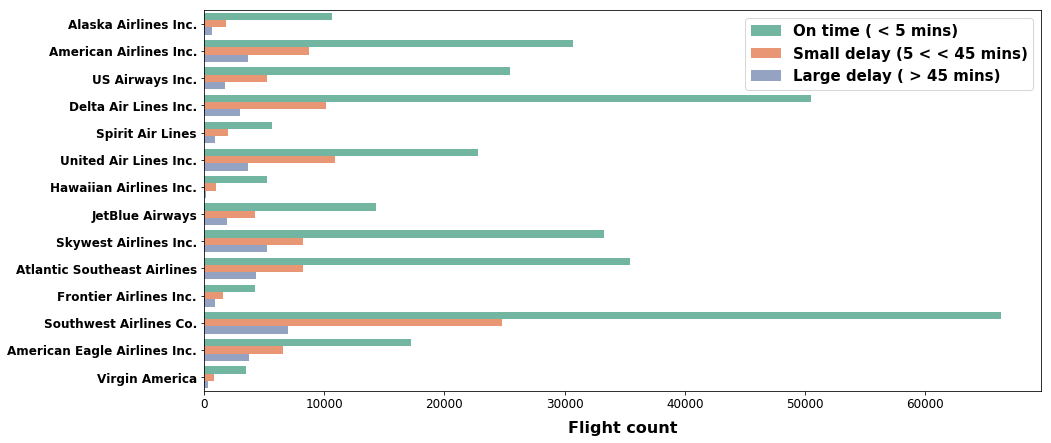

In [12]:
# Set delay type

# This lambda expression is amazing
delay_type = lambda x: ((0, 1)[x>5], 2)[x>45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)

fig = plt.figure(1, figsize=(15,7))
ax = sb.countplot(y='AIRLINE', hue='DELAY_LEVEL', data=df, palette="Set2")

labels = [airline_companies[i.get_text()] for i in ax.get_yticklabels()]
ax.set_yticklabels(labels)
ax.yaxis.label.set_visible(False)

plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);

plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)

# Set legend
L = plt.legend()
L.get_texts()[0].set_text('On time ( < 5 mins)')
L.get_texts()[1].set_text('Small delay (5 < < 45 mins)')
L.get_texts()[2].set_text('Large delay ( > 45 mins)')

plt.show()

Figure above showed delay counts by different delay type. Shall we normalize it to show this counting data? From this figure, Sourthwest is quite good on delay distribution.

#### 3.2 Delay distribution for each airline

The mean delay is quite homogeneous among all the airlines. Here we extract more details on each airline.

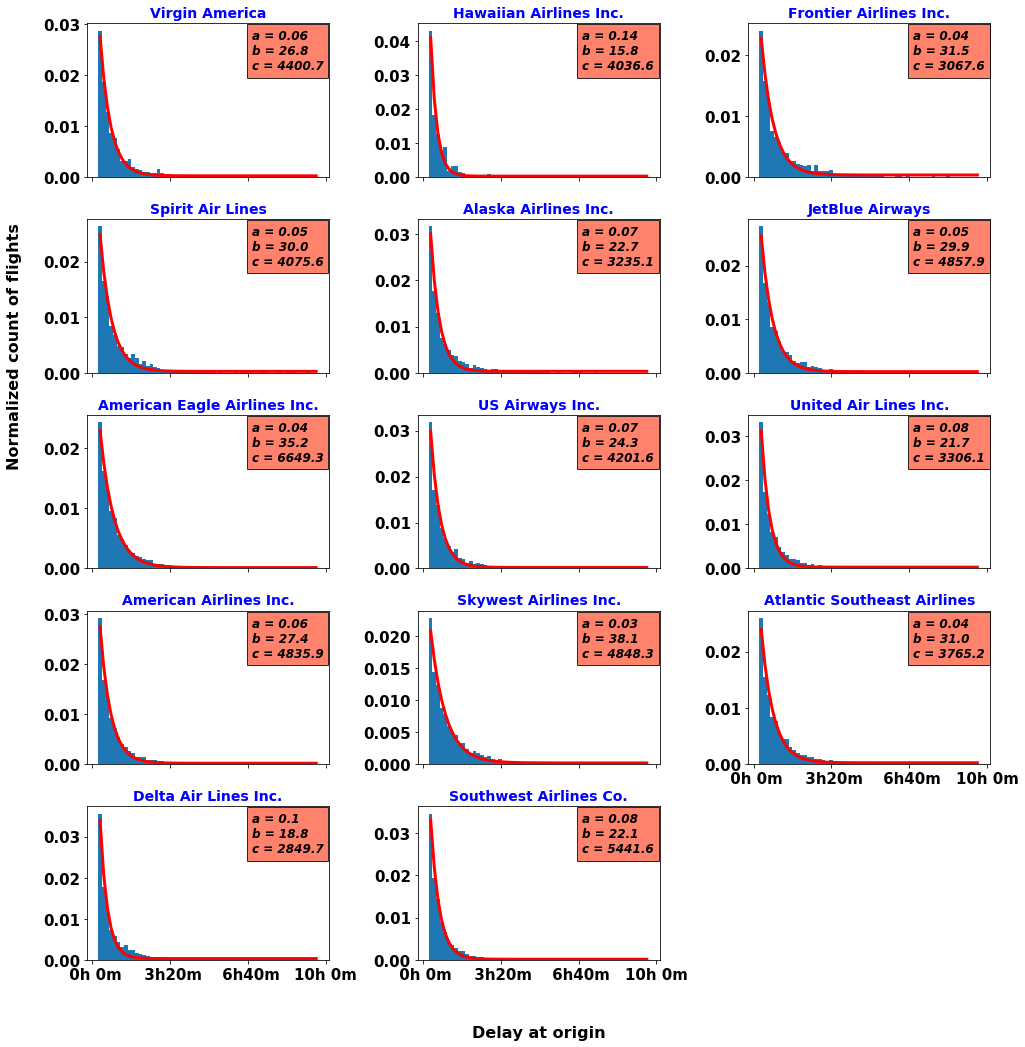

In [13]:
# Simple gaussian function, come from scipy documentation
def func(x, a, b, c):
    return a * np.exp(-x/b) + 1/c

points = []
label_company = []
fig = plt.figure(1, figsize=(14, 14))
i=0

for carrier in [airline_companies[i] for i in stats_by_airline.index]:
    i += 1
    ax = fig.add_subplot(5, 3, i)
    
    n, bins, patches = plt.hist(x = df2[df2.AIRLINE==carrier]['DEPARTURE_DELAY'], normed=True, range=(15,580), bins=60)
    bin_centers = bins[:-1] + 0.5 * (bins[1:] - bins[:-1])
    
    # Initial guess are guessed by tuning
    popt, pcov = curve_fit(func, bin_centers, n, p0=[1, 2, 1000])
    
    points.append(popt)
    label_company.append(carrier)
    
    # Draw fit curve
#     plt.scatter(bin_centers, func(bin_centers, *popt))
    plt.plot(bin_centers, func(bin_centers, *popt), 'r-', linewidth=3)
    
    if i < 12:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])
    
    # Title
    plt.title(carrier, fontsize=14, fontweight='bold', color='blue')
    
    # Labels
    if i == 4:
        ax.text(-0.3,0.9,'Normalized count of flights', fontsize=16, rotation=90,
            color='k', horizontalalignment='center', transform = ax.transAxes)
    if i == 14:
        ax.text( 0.5, -0.5 ,'Delay at origin', fontsize=16, rotation=0,
            color='k', horizontalalignment='center', transform = ax.transAxes)
        
    # legend for each plot
    ax.text(0.68, 0.7, 'a = {0}\nb = {1}\nc = {2}'.format(round(popt[0],2), round(popt[1],1), round(popt[2],1)),
            style='italic', transform=ax.transAxes, fontsize = 12, family='fantasy',
            bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})
    
plt.tight_layout()
plt.show()

The flight delay data have been normalized, hence we use modified version exponential function to fit $f(x)=a*exp(−x/b) + 1/c$ the histogram. Since the histogram is normalized, $\int f(x)dx$  almost equal to 1. So $a$ is corelated with $b$ as $a \to \frac{1}{b}$. The lower of ranking of a, the worse of large long delay amount of airlines. 

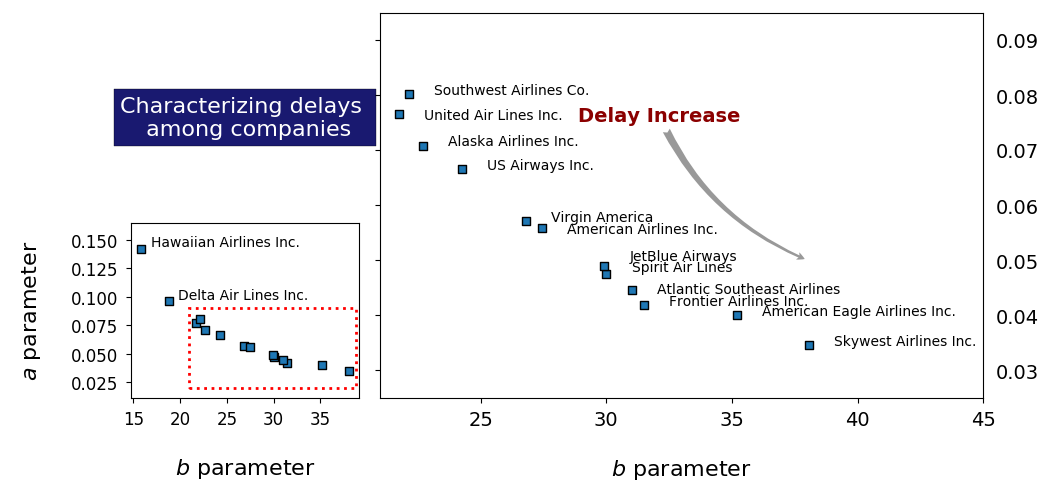

In [24]:
mpl.rcParams.update(mpl.rcParamsDefault)
sb.set_context('paper')

fig = plt.figure(1, figsize=(11,5))
y_shift = [0 for _ in range(14)]

y_shift[3] = 0.5/1000
y_shift[12] = 2.5/1000
y_shift[11] = -0.5/1000
y_shift[8] = -1/1000
y_shift[9] = -1/1000
y_shift[5] = 1/1000

x_val = [p[1] for p in points]
y_val = [p[0] for p in points]

gs=GridSpec(2,7)

# Left pane overview
ax1 = fig.add_subplot(gs[1,0:2])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolors='black', linewidths='1')

# Label for Hawaiian and Delta, the best 2 for a
xy_dev = 1
ax1.annotate(label_company[1], xy=(x_val[1]+xy_dev, y_val[1]+y_shift[i-1]), xycoords='data', fontsize=10)
ax1.annotate(label_company[12], xy=(x_val[12]+xy_dev, y_val[12]+y_shift[i-1]), xycoords='data', fontsize=10)
plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)
plt.ylabel("$a$ parameter", fontsize=16, labelpad=20)

ax1.text(.5, 1.5, 'Characterizing delays \n among companies', fontsize=16,
        bbox={'facecolor':'midnightblue', 'pad':5}, color='w',
        horizontalalignment='center', transform=ax1.transAxes)
    
# Create rectangular
rect = mpatches.Rectangle((21,0.02), 17.8, 0.07, linewidth=2, edgecolor='r', linestyle=':', facecolor='none')

ax1.add_patch(rect)

# Zoom in the rest
ax2=fig.add_subplot(gs[0:2, 2:])
plt.scatter(x=x_val, y=y_val, marker='s', edgecolors='black', linewidths='1')
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12)
ax2.set_xlim(21,45)
ax2.set_ylim(0.025,0.095)

for i in range(len(airline_companies)):
    ax2.annotate(label_company[i], xy=(x_val[i]+xy_dev, y_val[i]+y_shift[i]),
                 xycoords='data', fontsize = 10)

el = Ellipse((1, 1), 4, 2)
ax2.add_patch(el)
ax2.annotate('Delay Increase',
             xy=(38., .05), xycoords='data',
             xytext=(-165, 100), textcoords='offset points',
             size=14,
             color='darkred',
             weight='bold',
             arrowprops=dict(arrowstyle="fancy",
                            fc="0.6", ec="none",
                            patchB=el,
                            connectionstyle="Arc3, rad=0.2"))

#________________________________
# position and size of the ticks
plt.tick_params(labelleft=False, labelright=True)
plt.setp(ax2.get_xticklabels(), fontsize=14)
plt.setp(ax2.get_yticklabels(), fontsize=14)

plt.xlabel("$b$ parameter", fontsize=16, labelpad=20)

plt.show()

### 4. Departure delay of arrival delay

Figure out the mean delay for different airlines by departure delay and arrival delay

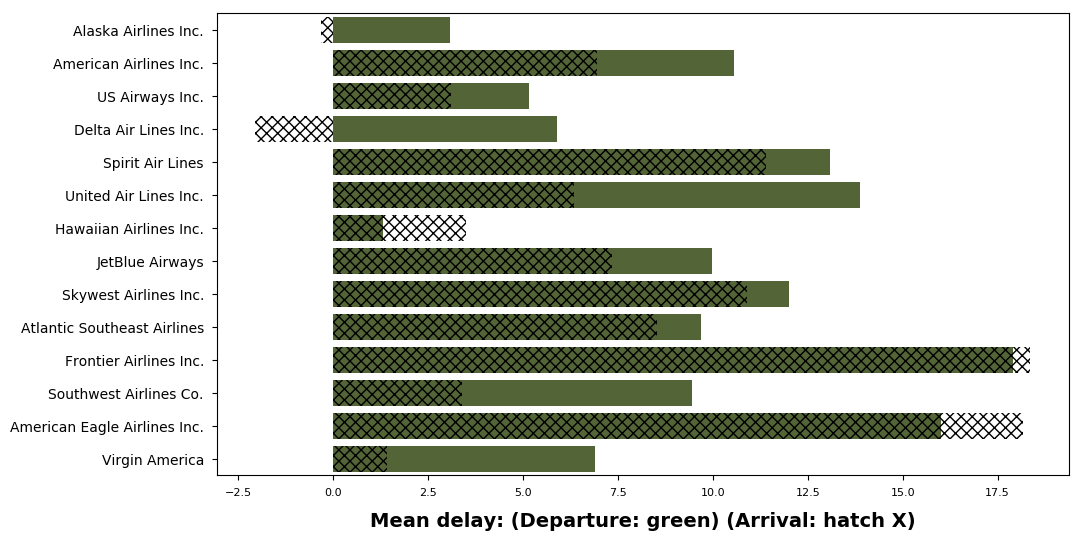

In [25]:
mpl.rcParams['hatch.linewidth']=1

fig = plt.figure(1, figsize=(11,6))
ax = sb.barplot(x='DEPARTURE_DELAY', y='AIRLINE', data=df, color='darkolivegreen', ci=None)
ax = sb.barplot(x='ARRIVAL_DELAY', y='AIRLINE', data=df, color='r', hatch='xxx', alpha=0.0, ci=None)

label=[airline_companies[i.get_text()] for i in ax.get_yticklabels()]
ax.set_yticklabels(label)
ax.yaxis.label.set_visible(False)
plt.setp(ax.get_yticklabels(), fontsize=10, ha='right')
plt.xlabel('Mean delay: (Departure: green) (Arrival: hatch X)', fontsize=14, weight='bold', labelpad=10)

plt.show()

Generally speak, most of the arrival delay are less than departure delay. Pilots may adjust the speed to avoid arrival delay if departure is already delay. Hence, in all following analysis, we will rely on departure delay. 

### 5. Find the relationship between delay and departure airport

Number of airports in this dataset:

In [26]:
print('Number of origin airports: {0}'.format(len(df['ORIGIN_AIRPORT'].unique())))

Number of origin airports: 312


#### 5.1 Geographical area covering stats

Simple analysis on the airports covered by each airline

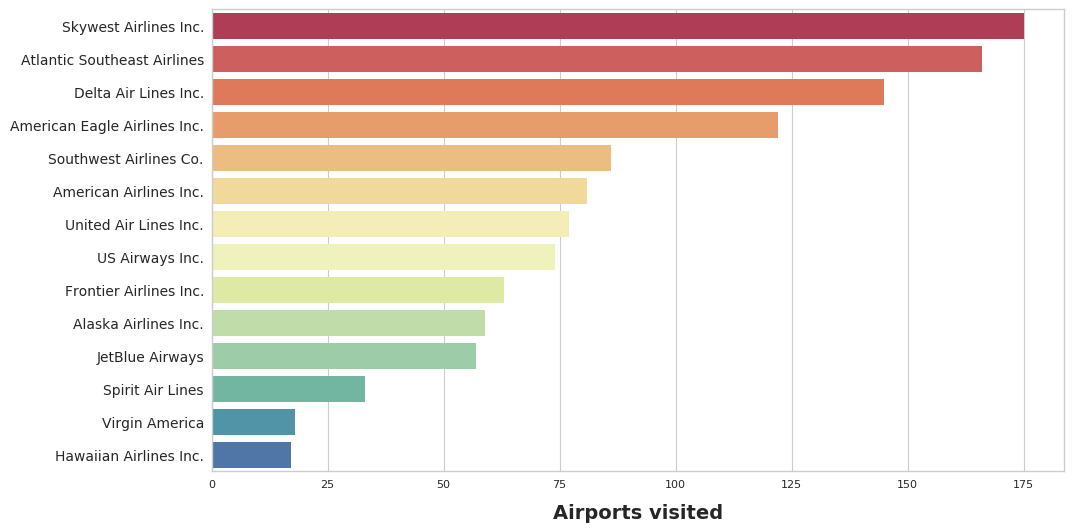

In [27]:
departure_airport_nb = dict()

for carrier in airline_companies.keys():
    departure_airport_nb[carrier] = len(df[df.AIRLINE == carrier].ORIGIN_AIRPORT.unique())

ca_df = pd.DataFrame.from_dict(departure_airport_nb, orient='index')
ca_df.columns=['AIRPORT_COUNT']
ca_df.sort_values('AIRPORT_COUNT', inplace=True, ascending=False)

sb.set_style('whitegrid')

fig = plt.figure(1, figsize=(11,6))
ax = sb.barplot(x='AIRPORT_COUNT', y=ca_df.index, data=ca_df, palette="Spectral", ci=None)
label=[airline_companies[i.get_text()] for i in ax.get_yticklabels()]
ax.set_yticklabels(label)
ax.yaxis.label.set_visible(False)
plt.xlabel('Airports visited', fontsize=14, weight='bold', labelpad=10)
plt.setp(ax.get_yticklabels(), fontsize=10, ha='right')
plt.show()

Sampling some airlines and plot their route geographical map.

In [28]:
latitude_airport = airports.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = airports.set_index('IATA_CODE')['LONGITUDE'].to_dict()

def geo_map(df, carrier, min_long, max_long, min_la, max_la):
    fig=plt.figure(figsize=(7,3))
    ax = fig.add_axes([0., 0, 1., 1.])
    m = Basemap(resolution='i', llcrnrlon=min_long, urcrnrlon=max_long, llcrnrlat=min_la, urcrnrlat=max_la, lat_0=0, lon_0=0)
    m.etopo()
    m.drawcoastlines()
    m.drawcountries(linewidth=3)
    m.drawstates(color='0.3')
    
    df3 = df[df['AIRLINE']==carrier]
    count_trajectories = df3.groupby(['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']).size()
    count_trajectories.sort_values(inplace = True)
    
    for (dep, arr), size in count_trajectories.iteritems():
        nylat,nylon = latitude_airport[dep], longitude_airport[dep]
        lonlat, lonlon = latitude_airport[arr], longitude_airport[arr]
        m.plot(nylon, nylat, marker='o', markersize=8, markeredgewidth=1, color='darkslategray', markeredgecolor='k')
        
        if pd.isnull(nylat) or pd.isnull(nylon) or pd.isnull(lonlat) or pd.isnull(lonlon): continue
            
        if size < 100: 
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=0.5, color='b', label = '< 100')
        elif size < 200:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='r', label = '100 <.< 200')
        else:
            m.drawgreatcircle(nylon, nylat, lonlon, lonlat, linewidth=2, color='gold', label = '> 200')
            
    
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    key_order = ('< 100', '100 <.< 200', '> 200')                
    new_label = OrderedDict()
    for key in key_order:
        if key not in by_label.keys(): continue
        new_label[key] = by_label[key]
    plt.legend(new_label.values(), new_label.keys(), loc = 'best', prop= {'size':8},
               title='flights per month', facecolor = 'palegreen', 
               shadow = True, frameon = True, framealpha = 1)  
    
    ax.set_title('{0} routes density'.format(airline_companies[carrier]), fontsize=16)
    plt.show()
        

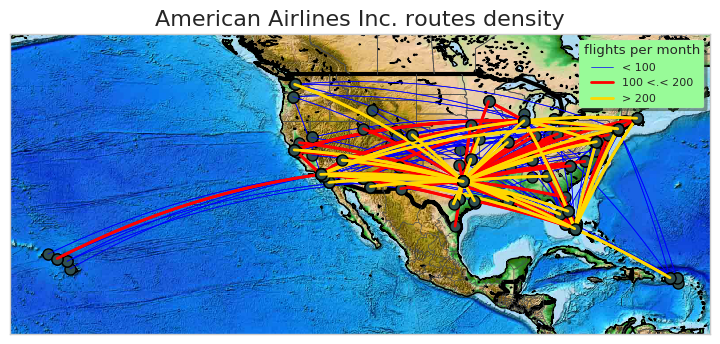

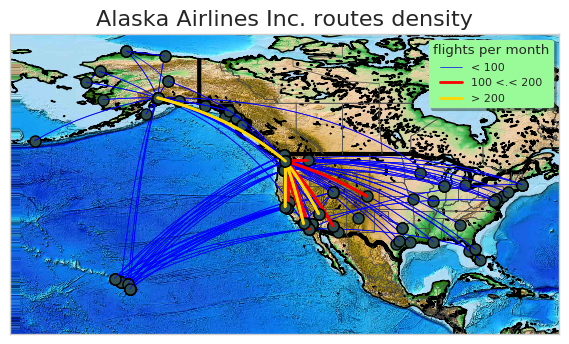

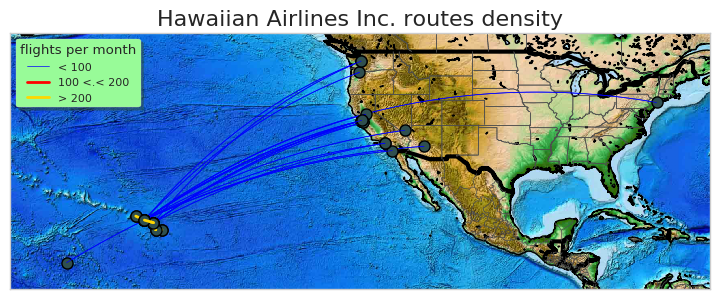

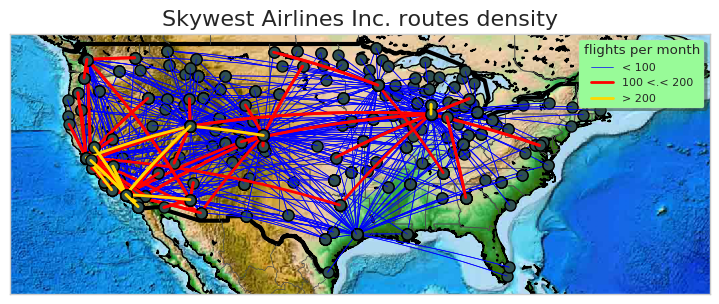

In [29]:
coord = dict()
coord['AA'] = [-165, -60, 10, 55]
coord['AS'] = [-182, -63, 10, 75]
coord['HA'] = [-180, -65, 10, 52]
coord['OO'] = [-130, -60, 24, 50]
for carrier in ['AA', 'AS', 'HA', 'OO']: 
    geo_map(df, carrier, *coord[carrier])

#### 5.2 How departure airport affect delay
Check the relationship between flight delay time and departure airport

In [30]:
airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN_AIRPORT'].unique()))
airport_mean_delays.set_index(0, drop=True, inplace=True)

for carrier in airline_companies.keys():
    df1 = df[df['AIRLINE'] == carrier]
    temp = df1['DEPARTURE_DELAY'].groupby(df['ORIGIN_AIRPORT']).apply(get_stat).unstack()
    airport_mean_delays[carrier] = temp.loc[:, 'MEAN'] 

We use two big matrix to show duration of delay by different airport and airline.

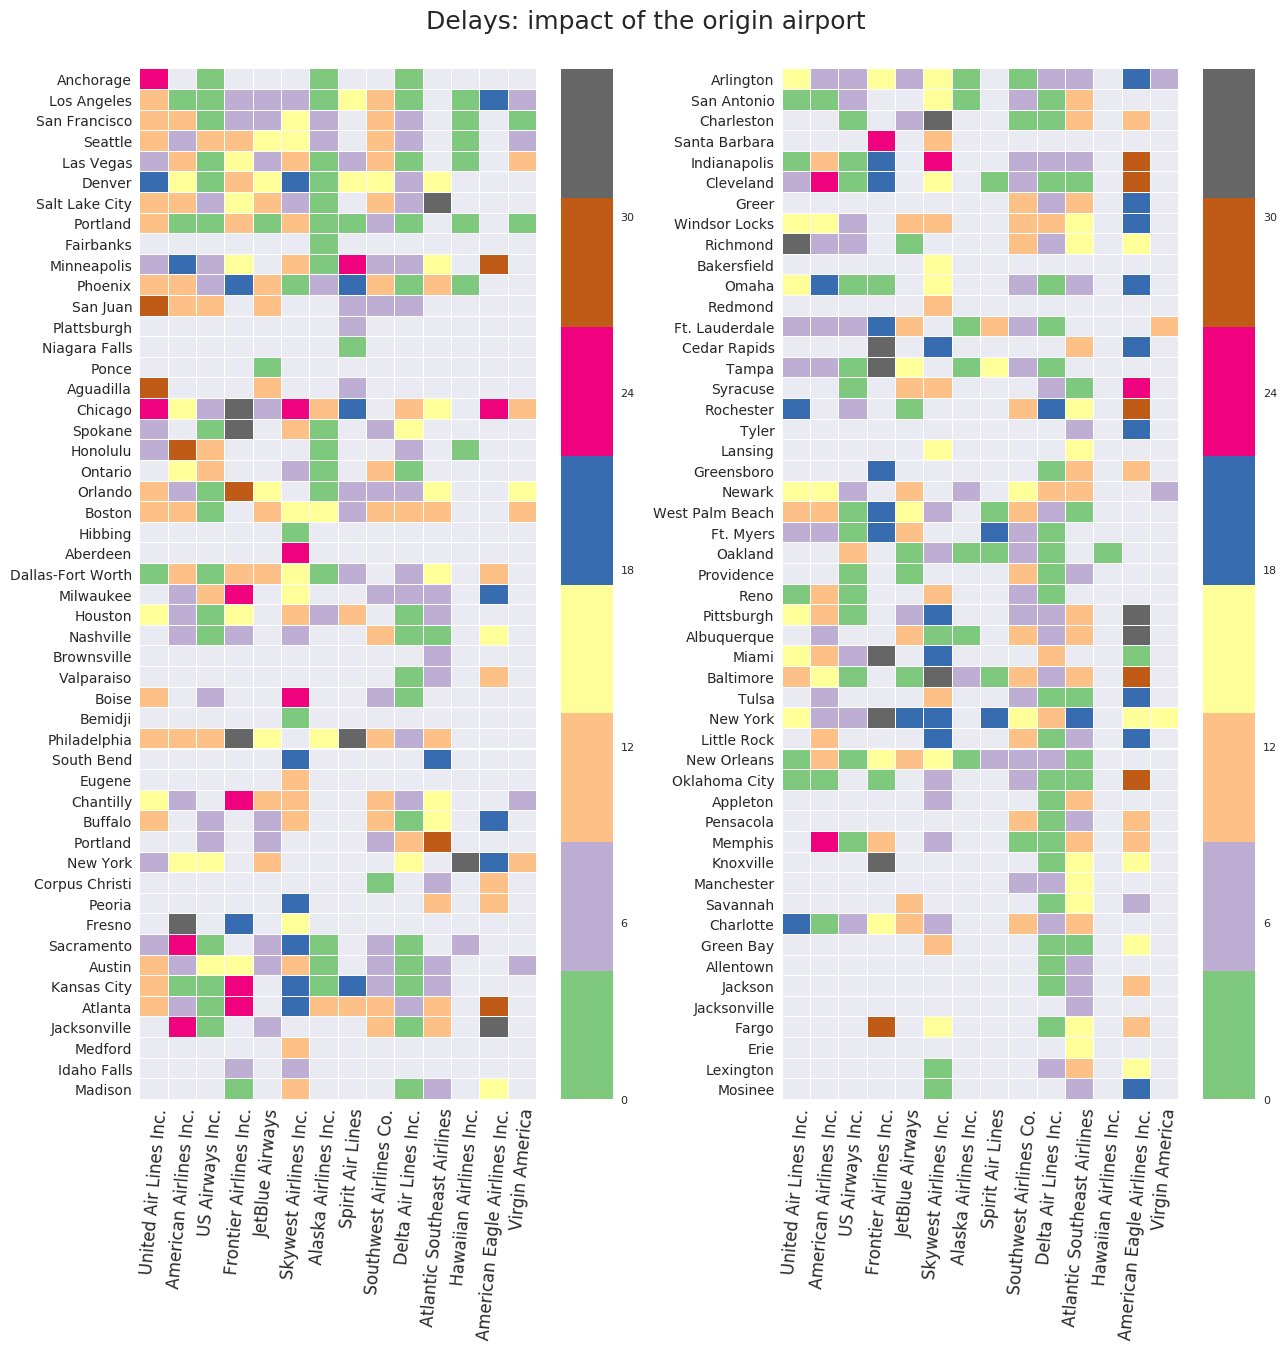

In [31]:
sb.set(context='paper')
fig = plt.figure(1, figsize=(13,13))

ax = fig.add_subplot(1, 2, 1)
subset = airport_mean_delays.iloc[:50,:].rename(columns = airline_companies)

identify_airport = airports.set_index('IATA_CODE')['CITY'].to_dict()

subset = subset.rename(index = identify_airport)
mask = subset.isnull()

sb.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 85) ;
plt.setp(ax.get_yticklabels(), fontsize=10) ;
ax.yaxis.label.set_visible(False)


ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:].rename(columns = airline_companies)
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sb.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=12, rotation = 85) ;
plt.setp(ax.get_yticklabels(), fontsize=10) ;
ax.yaxis.label.set_visible(False)


plt.tight_layout()
plt.show()

With these plots, we can figure out which airline usually reports long delay and which airports like departure late. 

#### 5.3 Relationship between delay and date/time

How date/time will affect delay time

In [106]:
class Figure_style():
    def __init__(self, size_x=11, size_y=5, nrows=1, ncols=1):
        sb.set_style("white")
        sb.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(size_x, size_y))
        
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
            
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
        
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
        
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
            
        
        
    
    def cust_plot_date(self, x, y, color='lightblue', linestyle='-',
                       linewidth=1, markeredge=False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].plot_date(x, y, color='lightblue', markeredgecolor='grey',
                                  markeredgewidth = markeredgewidth, label=label)
        
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)
    
    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)
        
    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
        
    def set_xlim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_xlim([lim_inf, lim_sup])
        
    def set_ylim(self, lim_inf, lim_sup):
        self.axs[self.ix, self.iy].set_ylim([lim_inf, lim_sup]) 

Choose United Airline as a candidate

In [104]:
carrier = 'UA'

id_airport = 4
liste_origin_airport = df[df['AIRLINE'] == carrier]['ORIGIN_AIRPORT'].unique()
df2 = df[(df['AIRLINE'] == carrier) & (df['ARRIVAL_DELAY'] > 0)
         & (df['ORIGIN_AIRPORT'] == liste_origin_airport[id_airport])]
df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
df2 = df2.iloc[:1000]

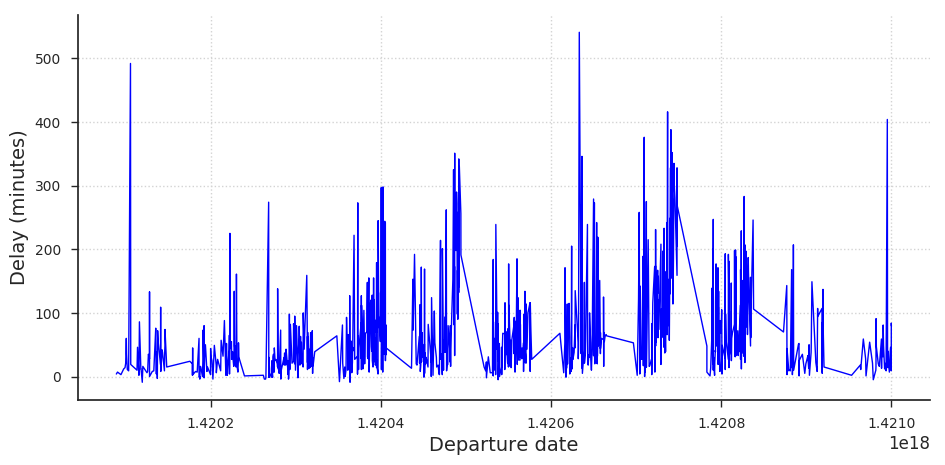

In [108]:
fig1 = Figure_style(11, 5, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_plot(df2['SCHEDULED_DEPARTURE'], df2['DEPARTURE_DELAY'], linestyle='-')
fig1.style() 
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure date', fontsize = 14)

# A date range is not really working, need to find out the reason.
# date_1 = datetime.datetime(2015,1,1)
# date_2 = datetime.datetime(2015,1,15)
# fig1.set_xlim(date_1, date_2)

# # UA has more delays
# fig1.set_ylim(-15, 260)

plt.show()

We will follow the same step from the study, which is to check the hypothesis that take-off time is the most important variable in the modelling of delay.

### 6. Predicting flight delays

We will use the first three weeks as data set to study on the delay prediction and last week data as ground truth to validate the correctness on different models

In [150]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train

#### 6.1 Model #1 one airline and one aiport

The basic study will be initialized by one airline and splitting date by different home airports. This is to test the model on the toy-model first, then apply to all dataset.

##### 6.1.1 Pitfalls

###### a. Unsufficient statistics
We use American Airlines and study on the number of flights left each airport: 

In [155]:
carrier = 'AA'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stat).unstack()
check_airports.sort_values('COUNT', ascending = False, inplace = True)
check_airports[-5:]

COUNT    MAX       MEAN   MIN        STD
ORIGIN_AIRPORT                                          
JAC              25.0   47.0  -3.640000 -19.0  15.694691
GUC              22.0  199.0  13.227273 -24.0  46.742386
SDF              19.0   55.0   8.421053  -8.0  18.727033
LIT               9.0   74.0  12.555556  -5.0  27.139045
MTJ               3.0   51.0  26.000000  -2.0  26.627054

Looking at this list, we can see that the less visited aiports only have a few flights in a month. Thus, in the least favorable case, it is impossible to perform a regression.

###### b.Extreme delays
Some extreme delays should be paid attention.This type of delay is however marginal (a few %) and the cause of these delays is probably linked to unpredictable events (weather, breakdown, accident, ...). On the other hand, taking into account a delay of this type will likely introduce a bias in the analysis. Moreover, the weight taken by large values will be significant if we have a small statistics.

To illustrate this, there is a function to calculate the mean flight delay per airline and airport:

In [159]:
def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
    #_______________________________________
    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    #__________________________________
    # Conversion: date + heure -> heure
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
    #___________________________________________________________________
    # regroupement des vols par heure de départ et calcul de la moyenne
    test2 = df2['DEPARTURE_DELAY'].groupby(df2['heure_depart']).apply(get_stat).unstack()
    test2.reset_index(inplace=True)
    #___________________________________
    # conversion de l'heure en secondes
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2.reset_index(inplace=True)
    test2['heure_depart_min'] = test2['heure_depart'].apply(fct)
    return test2

and then a function that performs a linear regression on these values:

In [161]:
def linear_regression(test2):
    test = test2[['MEAN', 'heure_depart_min']].dropna(how='any', axis = 0)
    X = np.array(test['heure_depart_min'])
    Y = np.array(test['MEAN'])
    X = X.reshape(len(X),1)
    Y = Y.reshape(len(Y),1)
    regr = linear_model.LinearRegression()
    regr.fit(X, Y)
    result = regr.predict(X)
    return X, Y, result

I then consider two scenarios. In the first case, I take all the initial values and in the second case, I eliminate all delays greater than 1h before calculating the average delay. The comparison of the two cases is quite explicit:

In [182]:
id_airport = 'LGA'
df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]
df2['heure_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())
df2['heure_depart'] = df2['heure_depart'].apply(lambda x:x.hour*3600+x.minute*60+x.second)
#___________________
# first case
test2 = get_flight_delays(df, carrier, id_airport, False)
X1, Y1, result2 = linear_regression(test2)
#___________________
# second case
test3 = get_flight_delays(df, carrier, id_airport, True)
X2, Y2, result3 = linear_regression(test3)

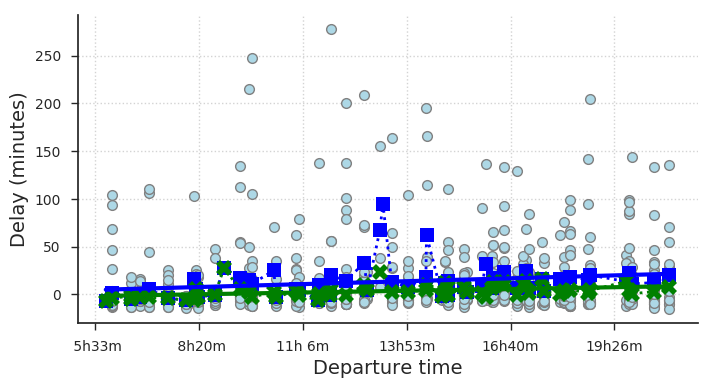

In [183]:
fig1 = Figure_style(8, 4, 1, 1)
fig1.pos_update(0, 0)
fig1.cust_scatter(df2['heure_depart'], df2['DEPARTURE_DELAY'], markeredge = True)
fig1.cust_plot(X1, Y1, color = 'b', linestyle = ':', linewidth = 2, marker = ('b','s', 10))
fig1.cust_plot(X2, Y2, color = 'g', linestyle = ':', linewidth = 2, marker = ('g','X', 12))
fig1.cust_plot(X1, result2, color = 'b', linewidth = 3)
fig1.cust_plot(X2, result3, color = 'g', linewidth = 3)
fig1.style()
fig1.set_ylabel('Delay (minutes)', fontsize = 14)
fig1.set_xlabel('Departure time', fontsize = 14)
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

plt.show()

The gray dots mean each flight delay. The blue dots are the mean value for all the flight delays. The green dots are the mean values when we remove the extreme delay data. From the graph, we noticed that the first case has a average 10 more mins than case 2 which we remove the extreme delays. 

Since the volume of the extreme delay is small, the impact of such delays will be less pronounced in the majority of cases.

##### 6.1.2 Polynomial degree

A simple linear regression is not always preferred. We can do a fit with different degree of polynomial order. The order of poynomial fit should be well toned in order to prevent over-fitting

A problem that may arise with this procedure is that the model ends by indirectly learning the contents of the test set and is thus biased. To avoid this, the data can be re-separated into 3 sets: train, test and validation. An alternative to this technique, which is often more robust, is the so-called cross-validation method. This method consists of performing a first separation of the data in training and test sets. As always, learning is done on the training set, but to avoid over-learning, it is split into several pieces that are used alternately for training and testing.

Note that if the data set is small, the separation in test & training sets can introduce a bias in the estimation of the parameters. In practice, the cross-validation method avoids such bias. In fact, in the current model, we will encounter this type of problem and in what follows, I will highlight this. For example, we can consider an extreme case where, after separation, the training set would contain only hours <20h and the test set would have hours> 20h. The model would then be unable to reproduce precisely this data, of which it would not have seen equivalent during the training. The cross-validation method avoids this bias because all the data are used successively to drive the model.

##### a. Bias introduced by the separation of the data set 
A fit_polynome is defined to test the impact on the data separation

In [187]:
class fit_polynome:

    def __init__(self, data):
        self.data = data[['MEAN', 'heure_depart_min']].dropna(how='any', axis = 0)

    def split(self, method):        
        self.method = method        
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['MEAN'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

        if method == 'all':
            self.X_train = self.X
            self.Y_train = self.Y
            self.X_test  = self.X
            self.Y_test  = self.Y                        
        elif method == 'split':            
            self.X_train, self.X_test, self.Y_train, self.Y_test = \
                train_test_split(self.X, self.Y, test_size=0.3)
    
    def train(self, pol_order):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X_train)
        self.regr.fit(self.X_, self.Y_train)
    
    def predict(self, X):
        self.X_ = self.poly.fit_transform(X)
        self.result = self.regr.predict(self.X_)
    
    def calc_score(self):        
        X_ = self.poly.fit_transform(self.X_test)
        result = self.regr.predict(X_)
        self.score = metrics.mean_squared_error(result, self.Y_test)



The fit_polynome class allows you to perform all operations related to a fit and to save the results. When calling the split() method, the variable 'method' defines how the initial data is separated:

    method = 'all' : all input data is used to train and then test the model
    method = 'split' : we use the train_test_split() method of sklearn to define test & training sets

Then, the other methods of the class have the following functions:

    train (n) : drives the data on the training set and makes a polynomial of order n
    predict (X) : calculates the Y points associated with the X input and for the previously driven model
    calc_score () : calculates the model score in relation to the test set data

In order to illustrate the bias introduced by the selection of the test set, I proceed in the following way: I carry out several "train / test" separation of a data set and for each case, I fit polynomials of orders n = 1, 2 and 3 , by calculating their respective scores. Then, I show that according to the choice of separation, the best score can be obtained with any of the values ​​of n . In practice, it is enough to carry out a dozen models to obtain this result. Moreover, this bias is introduced by the choice of the separation "train / test" and results from the small size of the dataset to be modeled. In fact, in the following, I take as an example the case of the airline American Airlines (the second biggest airline) and the airport of id 1129804, which is the airport with the most registered flights for that company. This is one of the least favorable scenarios for the emergence of this kind of bias, which, nevertheless, is present:


In [ ]:
fig = plt.figure(1, figsize=(10,4))

ax = ['_' for _ in range(4)]
ax[1]=fig.add_subplot(131) 
ax[2]=fig.add_subplot(132) 
ax[3]=fig.add_subplot(133) 

id_airport = 'BNA'
test2 = get_flight_delays(df, carrier, id_airport, True)

result = ['_' for _ in range(4)]
score = [10000 for _ in range(4)]
found = [False for _ in range(4)]
fit = fit_polynome(test2)

color = '.rgbyc'

inc = 0
while True:
    inc += 1
    fit.split('split')
    for i in range(1,4):
        fit.train(pol_order = i)
        fit.predict(fit.X)
        result[i] = fit.result
        fit.calc_score()
        score[i]  = fit.score

    [ind_min] = [j for j,val in enumerate(score) if min(score) == val]
    print("model nº{:<2}, min. pour n = {}, score = {:.1f}".format(inc, ind_min,score[ind_min]))
    
    if not found[ind_min]:            
        for i in range(1,4):
            ax[ind_min].plot(fit.X, result[i], color[i], linewidth = 4 if i == ind_min else 1)
        ax[ind_min].scatter(fit.X, fit.Y)                
        ax[ind_min].text(0.05, 0.95, 'MSE = {:.1f}, {:.1f}, {:.1f}'.format(*score[1:4]),
                         style='italic', transform=ax[ind_min].transAxes, fontsize = 8,
                         bbox={'facecolor':'tomato', 'alpha':0.8, 'pad':5})                
        found[ind_min] = True

    shift = 0.5
    plt.text(-1+shift, 1.05, "polynomial order:", color = 'k',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0+shift, 1.05, "n = 1", color = 'r', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.4+shift, 1.05, "n = 2", color = 'g', 
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
    plt.text(0.8+shift, 1.05, "n = 3", color = 'b',
                transform=ax[2].transAxes, fontsize = 16, family='fantasy')
   
    if inc == 40 or all(found[1:4]): break
        
plt.show()

In this figure, the panels from left to right correspond to 3 separations of the data in train and test sets, for which the best models are obtained respectively with polynomials of order 1, 2 and 3. On each of these panels the 3 fits polynomials have been represented and the best model corresponds to the thick curve.

##### b. Selection by cross-validation
One of the advantages of the cross-validation method is that it avoids the bias that has just been put forward when choosing the polynomial degree. A new fitting method is defined for this cross-validation

In [195]:
class fit_polynome_cv:

    def __init__(self, data):
        self.data = data[['MEAN', 'heure_depart_min']].dropna(how='any', axis = 0)
        self.X = np.array(self.data['heure_depart_min'])
        self.Y = np.array(self.data['MEAN'])
        self.X = self.X.reshape(len(self.X),1)
        self.Y = self.Y.reshape(len(self.Y),1)

    def train(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.result = cross_val_predict(self.regr, self.X_, self.Y, cv = nb_folds)
    
    def calc_score(self, pol_order, nb_folds):
        self.poly = PolynomialFeatures(degree = pol_order)
        self.regr = linear_model.LinearRegression()
        self.X_ = self.poly.fit_transform(self.X)
        self.score = np.mean(cross_val_score(self.regr, self.X_, self.Y,
                                             cv = nb_folds, scoring = 'mean_squared_error'))

This class has two methods:

    train (n, nb_folds) : defined 'nb_folds' training sets from the initial dataset and drives a 'n' order polynomial on each of these sets. This method returns as a result the Y predictions obtained for the different test sets.
    calc_score (n, nb_folds) : performs the same procedure as a train method except that this method calculates the fit score and not the predicted values ​​on the different test data.

By default, the 'K-fold' method is used by sklearn cross_val_predict () and cross_val_score () methods. These methods are deterministic in the choice of the K folds, which implies that for a fixed K value, the results obtained using these methods will always be identical. As seen in the previous example, this was not the case when using the train_test_split() method. Thus, if we take the same dataset as in the previous example, the method of cross validation makes it possible to choose the best polynomial degree:

In [196]:
#id_airport = 1129804 
nb_folds = 10
print('Max possible number of folds: {} \n'.format(test2.shape[0]-1))
fit2 = fit_polynome_cv(test2)
for i in range(1, 8):
    fit2.calc_score(i, nb_folds)
    print('n={} -> MSE = {}'.format(i, round(abs(fit2.score),3)))

Max possible number of folds: 16 

n=1 -> MSE = 130.629
n=2 -> MSE = 151.79
n=3 -> MSE = 159.456
n=4 -> MSE = 162.631
n=5 -> MSE = 166.966
n=6 -> MSE = 173.08
n=7 -> MSE = 181.361


We can see that using this method gives us that the best model (ie the best generalized model) is obtained with a polynomial of order 2. At this stage of the procedure, the choice of the polynomial order a has been validated and we can now use all the data in order to perform the fit:

In [197]:
fit = fit_polynome(test2)
fit.split('all')
fit.train(pol_order = 2)
fit.predict(fit.X)



Thus, in the following figure, the juxtaposition of the K = 50 polynomial fits corresponding to the cross validation calculation leads to the red curve. The polynomial fit corresponding to the final model corresponds to the blue curve.


In [198]:
fit2.train(pol_order = 2, nb_folds = nb_folds)

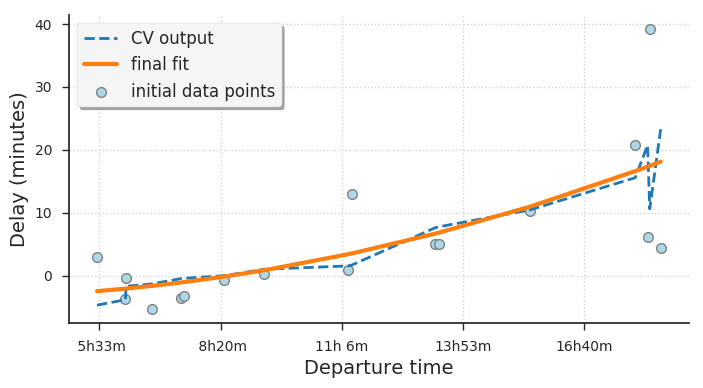

In [199]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(fit.X,fit2.result,color=u'#1f77b4',linestyle='--',linewidth=2,label='CV output')
fig1.cust_plot(fit.X,fit.result,color=u'#ff7f0e',linewidth = 3,label='final fit')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

plt.show()

In [200]:
score = metrics.mean_squared_error(fit.result, fit2.Y)
score

56.862847718920975

##### 6.1.3  Prediction of end-January delays

We will train the first 3 weeks of January and compare the predicted result with the 4th week ground truth data.

In [202]:
test_data = get_flight_delays(df_test, carrier, id_airport, True)
test_data = test_data[['MEAN', 'heure_depart_min']].dropna(how='any', axis = 0)
X_test = np.array(test_data['heure_depart_min'])
Y_test = np.array(test_data['MEAN'])
X_test = X_test.reshape(len(X_test),1)
Y_test = Y_test.reshape(len(Y_test),1)
fit.predict(X_test)

In [203]:
score = metrics.mean_squared_error(fit.result, Y_test)
score

108.67130851608422

The definition of MSE used here, for each point $i$, we have:

$y_i - f(x_i) = cste = \sqrt{MSE}$

thus giving the difference in minutes between the predicted delay and the actual delay. In this case, the difference between the model and the observations is thus typically:

In [204]:
'Ecart = {:.2f} min'.format(np.sqrt(score))

'Ecart = 10.42 min'

Here is the comarison of the final prediction and ground truth.

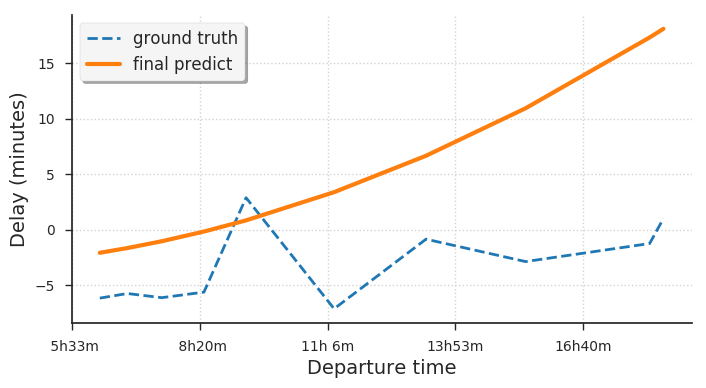

In [216]:
fig1 = Figure_style(8, 4, 1, 1) ; fig1.pos_update(0, 0)
# fig1.cust_scatter(fit2.X, fit2.Y, markeredge = True, label = 'initial data points')
fig1.cust_plot(X_test,Y_test,color=u'#1f77b4',linestyle='--',linewidth=2,label='ground truth')
fig1.cust_plot(X_test,fit.result,color=u'#ff7f0e',linewidth = 3,label='final predict')
fig1.style(); fig1.draw_legend('upper left')
fig1.set_ylabel('Delay (minutes)') ; fig1.set_xlabel('Departure time')
#____________________________________
# convert and set the x ticks labels
fct_convert = lambda x: (int(x/3600) , int(divmod(x,3600)[1]/60))
fig1.axs[fig1.ix, fig1.iy].set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*fct_convert(x))
                                            for x in fig1.axs[fig1.ix, fig1.iy].get_xticks()]);

plt.show()

####